In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7, 8"  # Use only the first GPU

import jax 
import jax.numpy as jnp
from jax import jit, random

import matplotlib.pyplot as plt


import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_LAXMAP, DIRECT_ACC_FOR_LOOP, DIRECT_ACC_MATRIX
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, MN_POTENTIAL, NFW_POTENTIAL
from odisseo.initial_condition import Plummer_sphere, ic_two_body, sample_position_on_sphere, inclined_circular_velocity, sample_position_on_circle, inclined_position
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot
from odisseo.potentials import MyamotoNagai, NFW

from odisseo.utils import halo_to_gd1_all, gd1_projection_vmap


plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})



In [2]:
from jax.scipy.integrate import trapezoid
from galpy.potential import MiyamotoNagaiPotential


def mass_enclosed_MN(R, z):
    """
    Compute the mass of the Myamoto-Nagai potential at a given radius R.

    """
    a = params.MN_params.a * code_units.code_length.to(u.kpc)
    b = params.MN_params.b * code_units.code_length.to(u.kpc)
    M = params.MN_params.M * code_units.code_mass.to( u.Msun)

    # Compute the mass using the Myamoto-Nagai formula
    mp = MiyamotoNagaiPotential(amp = M, a=a, b=b,) 

    return mp.mass(R, z) * u.Msun.to(code_units.code_mass)
    
@jit
def mass_enclosed_NFW(R):
    """
    Compute the mass of the NFW potential at a given radius R.

    ref: wikipedia
    """
    c = params.NFW_params.c
    Mvir = params.NFW_params.Mvir
    r_s = params.NFW_params.r_s
    rho_0 = (Mvir / (4*jnp.pi * r_s**3)) * (jnp.log(1+c) - c/(1+c))**-1

    return 4*jnp.pi*rho_0*r_s**3 * (jnp.log(1 + R/r_s) - R/(r_s + R))

code_length = 10.0 * u.kpc
code_mass = 1e8 * u.Msun
G = 1 
code_units = CodeUnits(code_length, code_mass, G=G)


# Define the 
config = SimulationConfig(N_particles = 10_000, 
                          return_snapshots = True, 
                          num_snapshots = 50, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL,  ), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.1 * u.kpc).to(code_units.code_length).value) #default values

params = SimulationParams(t_end = (1000 * u.Myr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(1e8 * u.Msun).to(code_units.code_mass).value,
                                                        a=(1 * u.kpc).to(code_units.code_length).value),
                           MN_params= MNParams(M=(6.5e10 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.3 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(1e12 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (15.0 * u.kpc).to(code_units.code_length).value,
                                               c = 8.0),                           
                          G=G, ) 

key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)

#put the Plummer sphere in a ciruclar orbit around the NFW halo
ra = 200*u.kpc.to(code_units.code_length)
e = 0.9
rp = (1-e)/(1+e) * ra

pos_com = sample_position_on_sphere(key=key,
                                r_p = rp,
                                num_samples=1,)
z = pos_com[0, 2]
inclination = jnp.pi/2 - jnp.acos(z/rp)

mass1 = mass_enclosed_MN(rp, z) + mass_enclosed_NFW(rp)
mass2 = params.Plummer_params.Mtot 
_, bulk_velocity, _ = ic_two_body(mass1=mass1,
                                mass2=mass2,
                                rp=rp,
                                e=e,
                                params=params)
bulk_velocity_modulus = bulk_velocity[1, 1].reshape((1))
vel_com = inclined_circular_velocity(pos_com, bulk_velocity_modulus, inclination)

# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state = construct_initial_state(positions, velocities)

    

In [ ]:
#run the simulation
snapshots = jax.block_until_ready(time_integration(initial_state, mass, config, params))


In [8]:
final_state = snapshots.states[-1].copy()
final_positions, final_velocities = final_state[:, 0], final_state[:, 1]

# compute the trasformqation to the GD1 coordinate system for 1 star
gd1_coordinate = halo_to_gd1_all(final_positions[0], final_velocities[0], code_units)
print("GD1 coordinate: ", gd1_coordinate)

# compute the transformation to the GD1 coordinate system for all stars
gd1_coordinate_vmapped = gd1_projection_vmap(final_positions, final_velocities, code_units)
print("shape of GD1 coordinate for all stars: ", gd1_coordinate_vmapped.shape)

GD1 coordinate:  [ 0.8608485  -1.6858103  -0.21196917 -5.1161366  19.497684   25.327383  ]
shape of GD1 coordinate for all stars:  (10000, 6)


Text(0, 0.5, '$v_{\\phi_2}$ [km/s]')

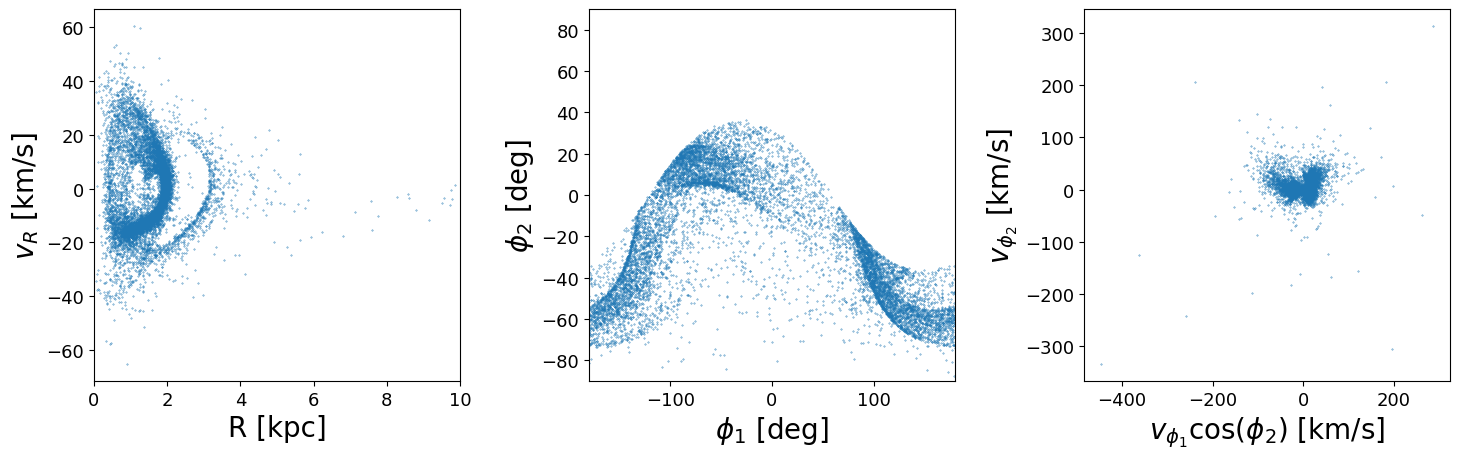

In [22]:
fig = plt.figure(figsize=(15, 5), tight_layout=True)
ax = fig.add_subplot(131)
ax.scatter(gd1_coordinate_vmapped[:, 0], gd1_coordinate_vmapped[:, 3], s=0.1)
ax.set_xlabel("R [kpc]")
ax.set_ylabel("$v_R$ [km/s]")
ax.set_xlim(0, 10)

ax = fig.add_subplot(132)
ax.scatter(jnp.rad2deg(gd1_coordinate_vmapped[:, 1]), jnp.rad2deg(gd1_coordinate_vmapped[:, 2]), s=0.1)
ax.set_xlabel("$\phi_1$ [deg]")
ax.set_ylabel("$\phi_2$ [deg]")
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)

ax = fig.add_subplot(133)
ax.scatter(gd1_coordinate_vmapped[:, 4]*jnp.cos(gd1_coordinate_vmapped[:, 2]), gd1_coordinate_vmapped[:, 5], s=0.1)
ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [km/s]")
ax.set_ylabel("$v_{\phi_2}$ [km/s]")
